In [1]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi import *


%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()



Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_10406/1069408875.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [2]:

def subset_data(Y, E, G, n_samples=50000, seed=42):
    """
    Subset the data to n_samples individuals while maintaining consistency
    
    Args:
        Y: tensor of shape [N, D, T]
        E: tensor of shape [N, D]
        G: tensor of shape [N, P]
        n_samples: number of individuals to keep
        seed: random seed for reproducibility
    
    Returns:
        Y_sub, E_sub, G_sub: subsetted tensors
    """
    torch.manual_seed(seed)
    
    # Get total number of individuals
    N = Y.shape[0]
    
    # Randomly select n_samples indices
    indices = torch.randperm(N)[:n_samples]
    
    # Subset all matrices using the same indices
    Y_sub = Y[indices]
    E_sub = E[indices]
    G_sub = G[indices]
    
    print(f"Original shapes: Y={Y.shape}, E={E.shape}, G={G.shape}")
    print(f"New shapes: Y={Y_sub.shape}, E={E_sub.shape}, G={G_sub.shape}")
    
    return Y_sub, E_sub, G_sub, indices

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 74 diseases
Cluster 2: 30 diseases
Cluster 3: 7 diseases
Cluster 4: 23 diseases
Cluster 5: 10 diseases
Cluster 6: 17 diseases
Cluster 7: 14 diseases
Cluster 8: 21 diseases
Cluster 9: 5 diseases
Cluster 10: 8 diseases
Cluster 11: 9 diseases
Cluster 12: 12 diseases
Cluster 13: 31 diseases
Cluster 14: 25 diseases
Cluster 15: 5 diseases
Cluster 16: 9 diseases
Cluster 17: 17 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases
Initialization complete!

Using psi configuration
Initialization complete!


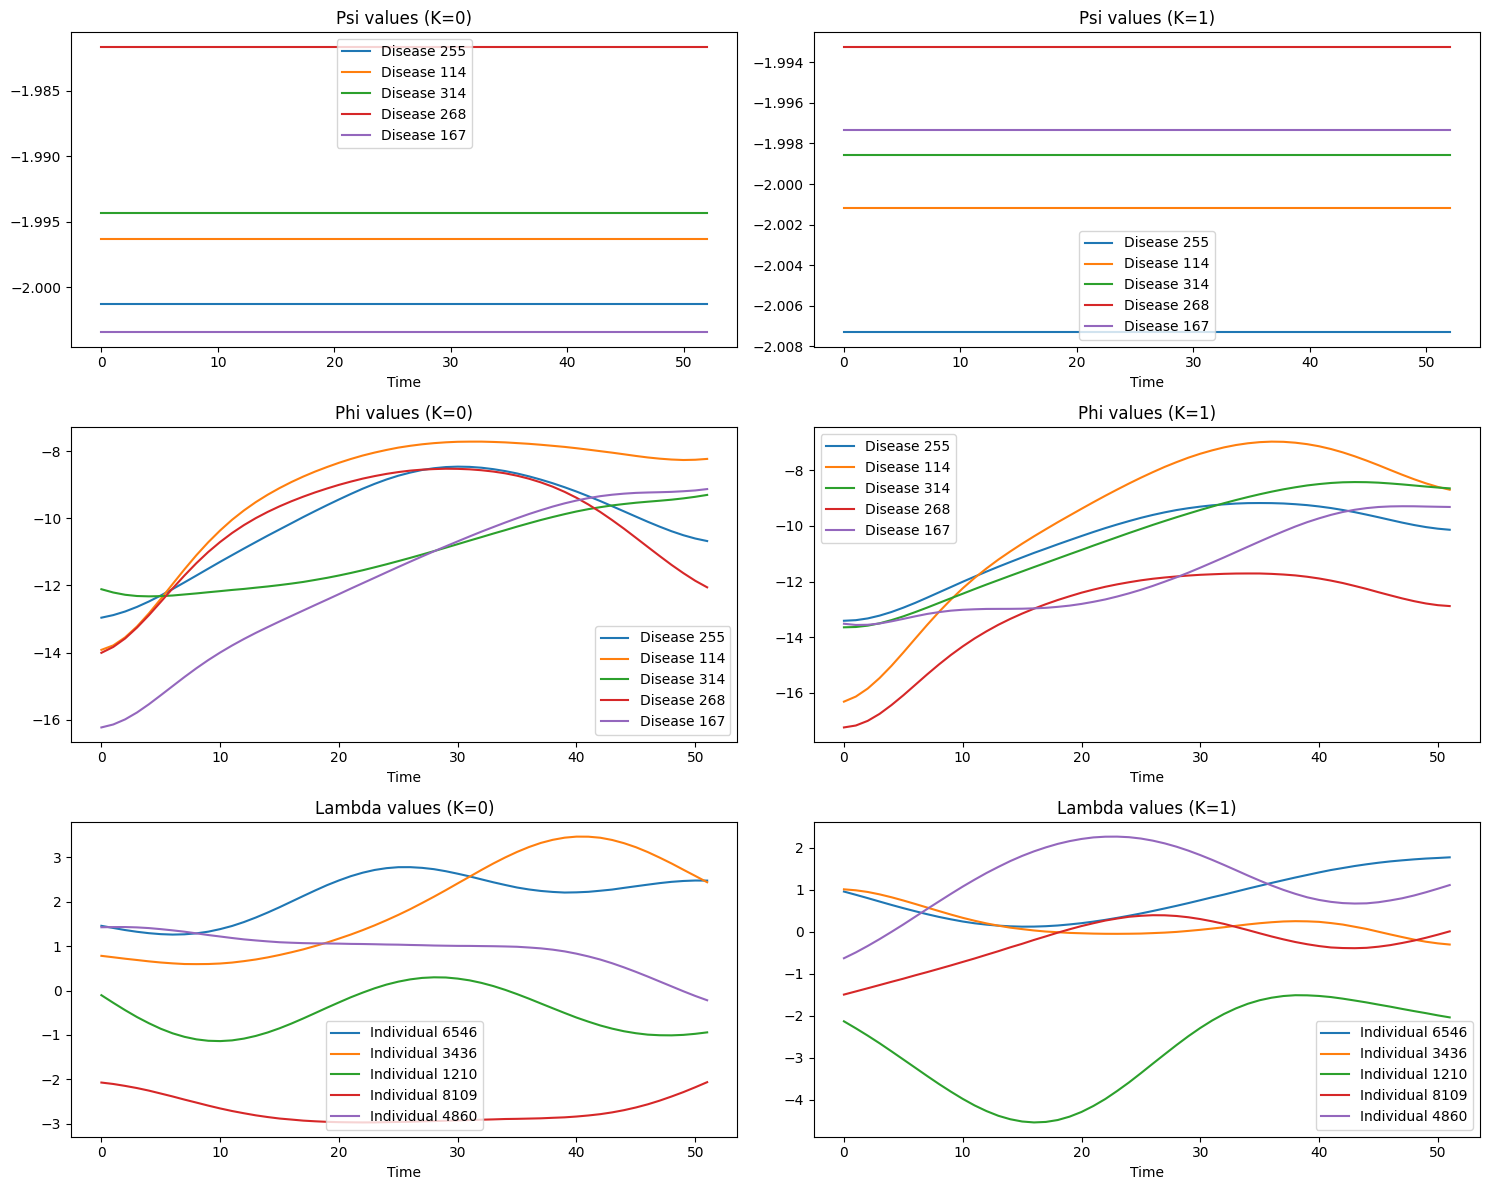


Cluster membership for sampled diseases:
Disease 255: Cluster 13
Disease 114: Cluster 3
Disease 314: Cluster 4
Disease 268: Cluster 14
Disease 167: Cluster 18


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:709: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


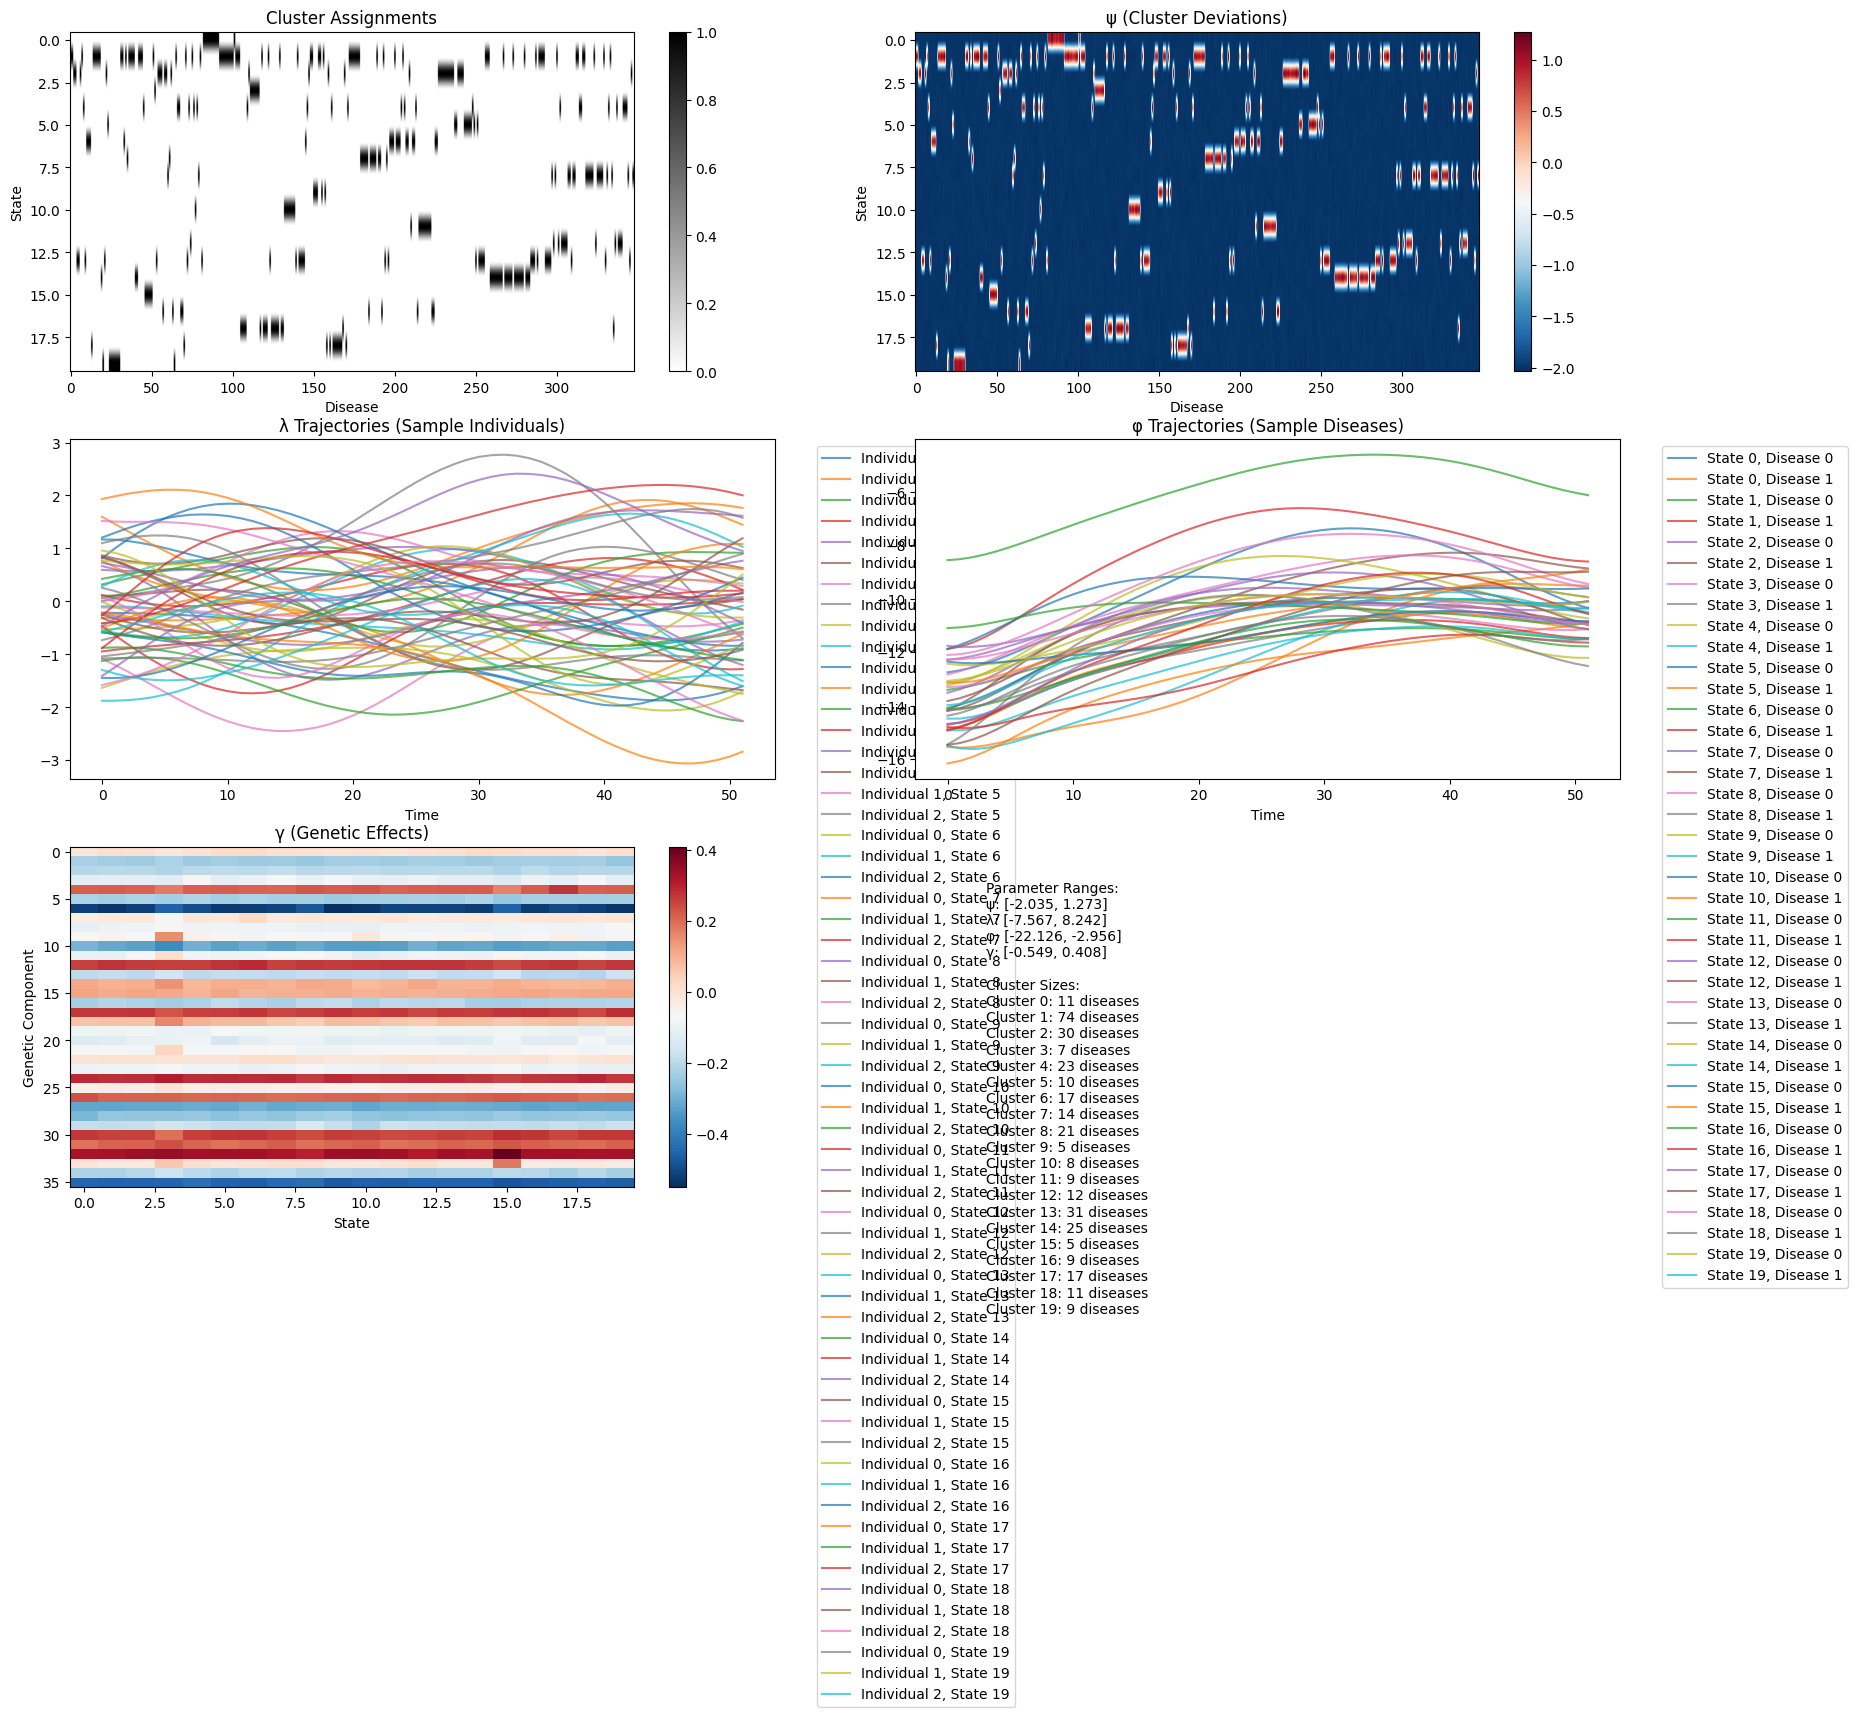

In [3]:
# When initializing the model:
original_G = G_100k.clone().detach()  # Store the original G - proper tensor copy

psi_config = {'in_cluster': 1, 'out_cluster': -2, 'noise_in': 0.1, 'noise_out': 0.01}
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0],
    D=Y_100k.shape[1],
    T=Y_100k.shape[2],
    K=essentials['K'],
    P=essentials['P'],
    G=G_100k,
    Y=Y_100k,
    prevalence_t=essentials['prevalence_t']
)

model.initialize_params(psi_config=psi_config)
model.plot_initial_params()
model.visualize_initialization()


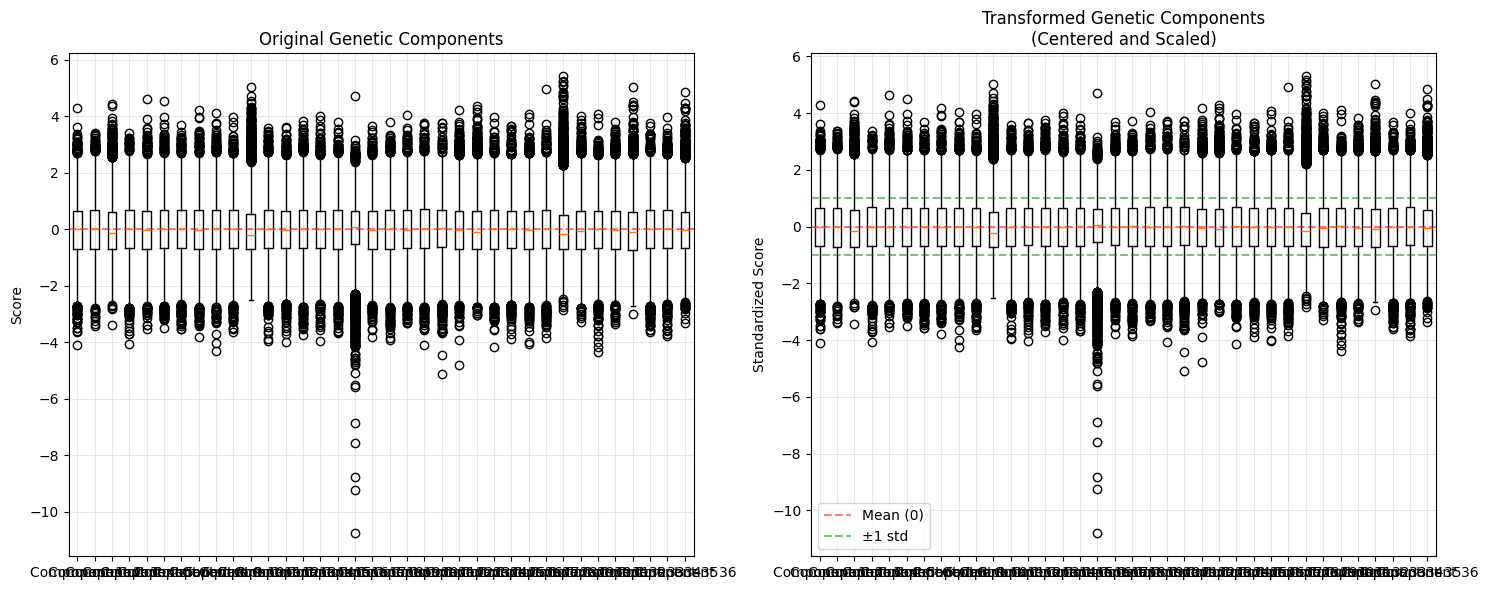


Genetic Components Summary Statistics:
Component  Original Mean Original Std  Trans. Mean  Trans. Std
------------------------------------------------------------
1                 -0.001        0.999        0.000       1.000
2                  0.011        1.003       -0.000       1.000
3                  0.012        0.994        0.000       1.000
4                  0.007        1.002       -0.000       1.000
5                 -0.007        0.994       -0.000       1.000
6                  0.008        1.006       -0.000       1.000
7                  0.031        0.994       -0.000       1.000
8                  0.003        1.009        0.000       1.000
9                  0.006        1.014        0.000       1.000
10                 0.012        0.999        0.000       1.000
11                 0.008        1.000       -0.000       1.000
12                 0.012        0.999       -0.000       1.000
13                -0.005        0.989       -0.000       1.000
14               

In [65]:

# Plot both versions:
model.plot_genetic_scores(original_G)
print(model.G[:,3].mean())

print(original_G[:,3].mean())


# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")

G_mean_o = original_G.mean(dim=0)
G_std_o = original_G.std(dim=0)

print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean_o.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std_o - 1).abs().max().item():.6f}")

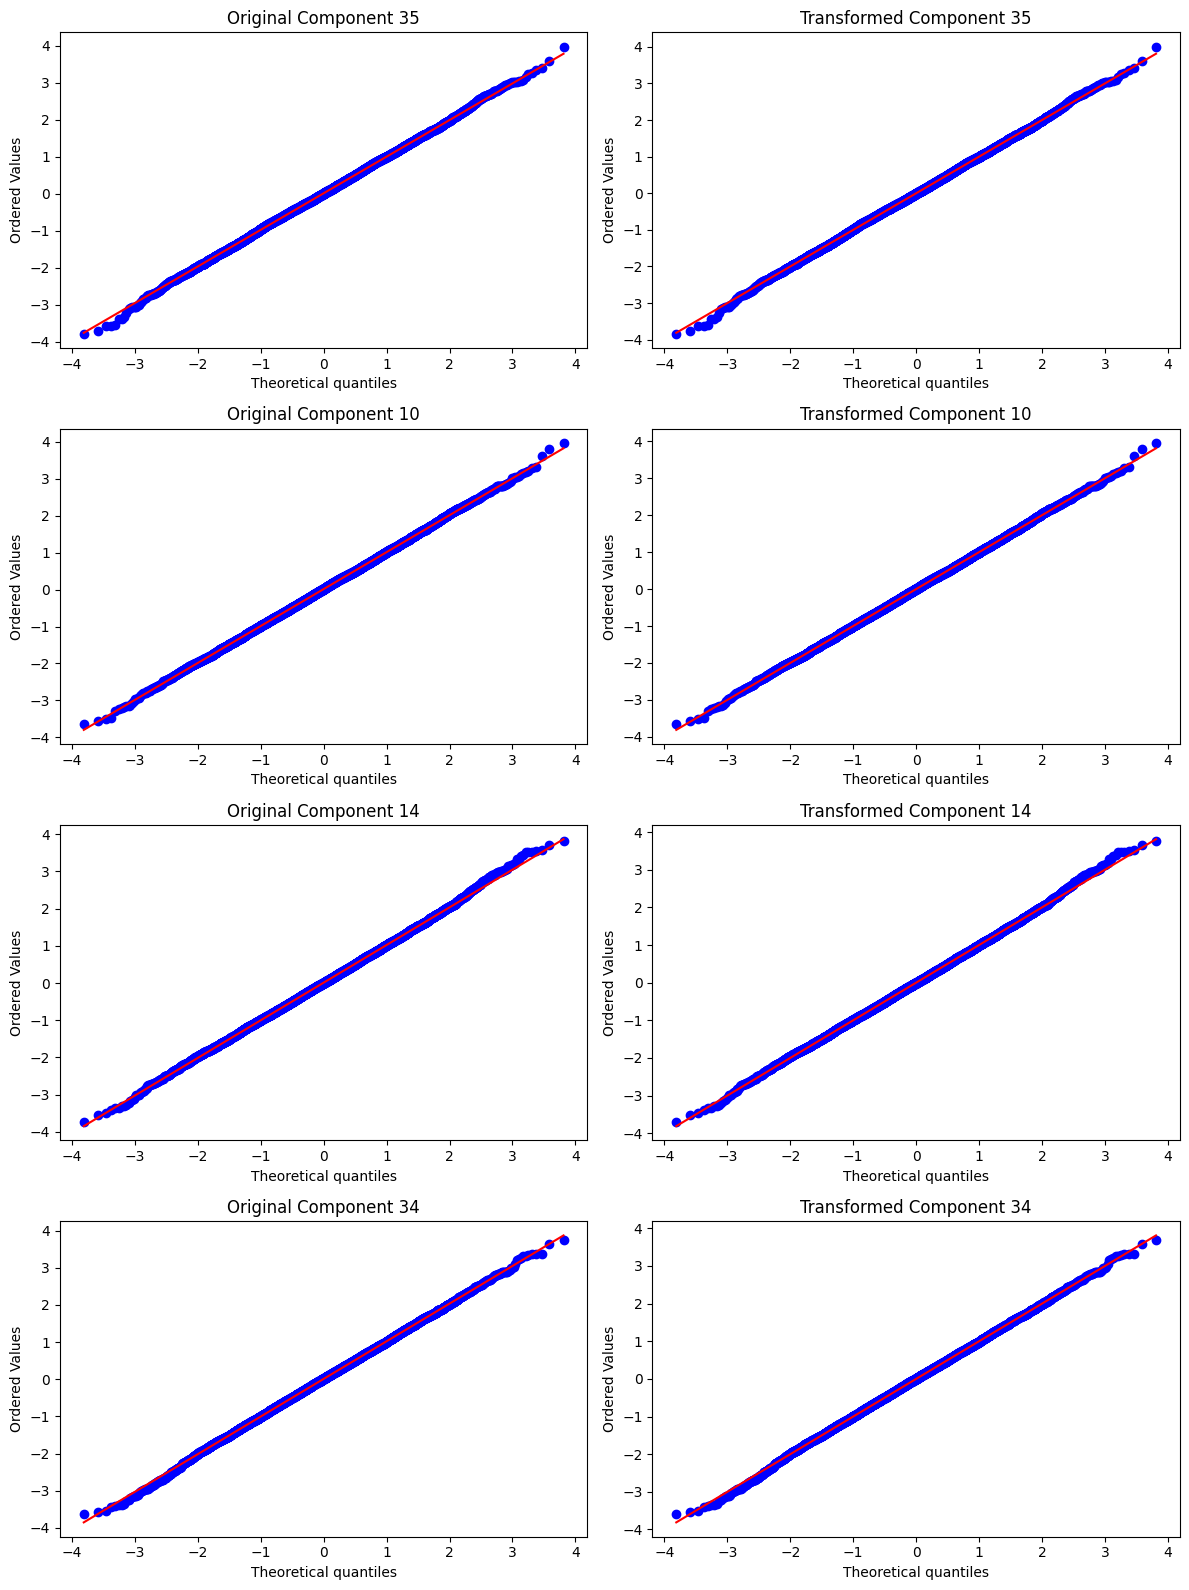

In [44]:
model.plot_qq_genetic_scores(original_G)

In [56]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


In [57]:
model.fit??

Signature:
model.fit(
    event_times,
    num_epochs=1000,
    learning_rate=0.0001,
    lambda_reg=0.01,
    convergence_threshold=0.001,
    patience=10,
)
Source:   
    def fit(self, event_times, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2,
        convergence_threshold=1e-3, patience=10):
        """
        Fit model with early stopping and parameter monitoring
        
        optimizer = optim.Adam([
            {'params': [self.lambda_, self.phi,self.psi]},
            {'params': [self.gamma], 'weight_decay': lambda_reg}
        ], lr=learning_rate)
        """

            # Create optimizer with consistent learning rates
        optimizer = optim.Adam([
            {'params': [self.lambda_, self.phi], 'lr': learning_rate},
            {'params': [self.psi], 'lr': learning_rate},  # Same base learning rate
            {'params': [self.gamma], 'weight_decay': lambda_reg, 'lr': learning_rate}
        ])

        
        history = {
            'loss': [],
           

In [59]:
initial_phi

tensor([[[-13.8988, -13.8356, -13.7384,  ..., -11.0269, -11.1999, -11.3511],
         [-13.1459, -13.0792, -12.9635,  ..., -10.4920, -10.6221, -10.7437],
         [-15.0618, -15.0095, -14.8724,  ...,  -9.6292,  -9.6459,  -9.6668],
         ...,
         [-13.4122, -13.3086, -13.1813,  ..., -12.3414, -12.2625, -12.1688],
         [-16.2623, -16.1513, -15.9299,  ...,  -8.6321,  -8.6185,  -8.6002],
         [-15.1660, -15.0248, -14.7832,  ..., -10.1704, -10.1822, -10.1612]],

        [[ -8.2680,  -8.2216,  -8.1529,  ...,  -8.5960,  -8.6320,  -8.6420],
         [-11.7996, -11.7479, -11.6479,  ...,  -7.5859,  -7.5812,  -7.5664],
         [-18.4812, -18.3805, -18.1791,  ..., -10.8359, -10.7632, -10.6806],
         ...,
         [-11.9441, -12.0004, -12.0317,  ...,  -9.3092,  -9.3829,  -9.4557],
         [-15.9659, -15.8537, -15.6298,  ...,  -9.3851,  -9.3749,  -9.3597],
         [-16.2964, -16.3662, -16.3471,  ..., -11.1063, -11.1297, -11.1232]],

        [[-12.6071, -12.5226, -12.4100,  ...

In [7]:
initial_gamma

tensor([[-1.2960e-02,  4.6540e-03,  1.6287e-03, -1.5053e-02, -4.2092e-04,
          1.6932e-02,  2.1446e-02,  3.5832e-03, -6.8771e-04, -8.6195e-03,
          1.6670e-04, -1.4271e-02, -2.2448e-03,  6.2877e-04,  2.3186e-02,
          1.2095e-02,  1.2525e-03,  7.6934e-03, -1.1566e-02,  9.7693e-03],
        [-2.2430e-01, -2.3607e-01, -2.4155e-01, -2.2063e-01, -2.4280e-01,
         -2.3736e-01, -2.4573e-01, -2.4156e-01, -2.5045e-01, -2.3748e-01,
         -2.3757e-01, -2.4017e-01, -2.2834e-01, -2.3261e-01, -2.4629e-01,
         -2.3860e-01, -2.2975e-01, -2.3232e-01, -2.2934e-01, -2.5411e-01],
        [-2.0552e-01, -1.9808e-01, -2.0495e-01, -2.1587e-01, -1.9699e-01,
         -1.9227e-01, -1.9559e-01, -1.8863e-01, -2.0427e-01, -1.9873e-01,
         -1.9626e-01, -2.0276e-01, -2.0458e-01, -1.9808e-01, -1.9945e-01,
         -2.1663e-01, -1.9191e-01, -2.1188e-01, -2.0572e-01, -2.0577e-01],
        [-1.2554e-01, -1.1734e-01, -1.1372e-01, -1.2022e-01, -6.5344e-02,
         -1.1676e-01, -9.9148e-02, 

In [4]:

history = model.fit(E_100k, num_epochs=200, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 1109.1042
Psi gradient stats:
Mean: -4.1142e-05
Std:  4.7490e-03
Max:  1.7403e-02
Min:  -1.9418e-02
Epoch 0, Loss: 1109.1042, Gradients - Lambda: 5.413e-01, Phi: 1.365e+01, Gamma: 6.317e-02, Psi: 1.942e-02


In [5]:
E_100k

tensor([[24, 51, 51,  ..., 51, 51, 51],
        [51, 51, 51,  ..., 51, 51, 51],
        [51, 51, 51,  ..., 51, 51, 51],
        ...,
        [51, 51, 51,  ..., 51, 51, 51],
        [51, 51, 51,  ..., 51, 51, 51],
        [51, 51, 51,  ..., 51, 51, 51]])

In [15]:
model.gamma-initial_gamma

tensor([[ 6.4671e-03, -7.2331e-03, -1.0052e-02,  6.8658e-03,  1.5932e-03,
          5.4295e-03,  2.0079e-06, -3.2287e-03,  6.1787e-04,  9.2513e-05,
         -6.3457e-03,  6.1242e-03, -1.1689e-03, -1.0846e-02, -2.3770e-03,
         -1.0570e-02,  4.8197e-03,  1.7223e-03, -2.0095e-03, -3.1845e-03],
        [-2.0811e-03,  2.9030e-04,  1.0394e-02, -1.2628e-03,  1.3357e-03,
         -3.8475e-04,  2.3005e-03,  7.5013e-03,  7.3196e-03,  1.7564e-04,
         -2.8379e-03, -5.8621e-03,  4.2131e-03, -9.9090e-03, -6.0245e-03,
          1.4008e-03, -5.4565e-03,  8.2724e-04, -5.5795e-03, -4.3253e-03],
        [ 1.7508e-03,  3.1340e-03,  5.6760e-03,  2.4057e-03,  1.5579e-03,
         -2.6069e-03,  1.3044e-02, -1.3792e-02,  2.7071e-03,  3.5910e-03,
         -5.4282e-03,  5.4039e-03, -2.2805e-03, -1.5067e-03,  8.0509e-03,
          5.4125e-04,  6.8489e-04,  3.2862e-03, -1.4379e-03,  9.1832e-03],
        [ 5.2340e-03,  2.1572e-03,  3.8631e-03,  6.3571e-03,  1.3592e-03,
          4.7857e-04,  8.1016e-03, 

In [16]:
model.phi-initial_phi

tensor([[[ 3.4695e-03, -1.0605e-03,  5.2452e-05,  ..., -6.1893e-04,
          -1.2283e-03, -4.5776e-05],
         [-1.0557e-03,  6.2370e-04,  4.1962e-04,  ...,  3.9864e-04,
           6.0749e-04,  3.7470e-03],
         [-1.0532e-02, -5.4512e-03, -1.7624e-03,  ..., -8.5831e-06,
           2.3699e-03,  3.5696e-03],
         ...,
         [ 6.6862e-03,  3.5162e-03, -3.2711e-04,  ..., -1.4439e-03,
          -6.0749e-04,  3.8109e-03],
         [-1.4668e-03, -1.0872e-04,  8.2016e-04,  ..., -7.4196e-04,
          -1.7929e-03,  3.9530e-04],
         [ 6.3963e-03,  7.4100e-04, -3.1948e-04,  ...,  2.9402e-03,
          -2.9469e-04, -4.5376e-03]],

        [[-3.0422e-04,  1.0834e-03, -3.6430e-04,  ...,  5.6791e-04,
          -1.3576e-03, -1.3552e-03],
         [-4.6921e-04, -1.3866e-03, -4.1389e-04,  ...,  2.8419e-04,
          -1.4696e-03, -1.1034e-03],
         [ 7.0210e-03,  3.5095e-04,  2.9564e-04,  ...,  1.0796e-03,
          -1.9474e-03, -7.3671e-03],
         ...,
         [-6.2933e-03, -7

In [18]:
model.lambda_-initial_lambda

tensor([[[-1.9530e-03,  6.4842e-04,  1.3762e-03,  ..., -1.0408e-03,
          -1.2405e-03, -3.0562e-03],
         [-3.7582e-04, -4.0923e-04, -1.5926e-03,  ...,  1.9802e-03,
           2.1434e-04, -3.1435e-03],
         [ 7.7838e-03,  8.5831e-04, -4.0224e-03,  ...,  9.1815e-04,
          -1.6787e-03,  3.4259e-03],
         ...,
         [-5.0590e-03, -1.7470e-03, -4.7016e-04,  ..., -3.9331e-03,
          -2.8236e-03,  4.7663e-03],
         [ 9.8535e-03,  4.0813e-03, -5.1701e-04,  ...,  1.6870e-03,
          -1.3411e-04,  3.0339e-04],
         [ 6.5733e-03,  2.3171e-03,  7.7003e-04,  ...,  2.0606e-03,
           4.5172e-03,  1.0185e-02]],

        [[ 5.0029e-03,  7.3364e-04, -2.6699e-03,  ...,  3.6438e-03,
           1.2084e-03, -7.1675e-03],
         [ 4.6110e-04,  1.0946e-03, -2.4883e-03,  ..., -1.0759e-03,
          -6.7723e-04, -2.3428e-03],
         [ 7.5292e-03, -1.2556e-04, -2.4661e-03,  ...,  2.3556e-03,
           1.5660e-03, -5.6577e-03],
         ...,
         [-5.3448e-03, -1

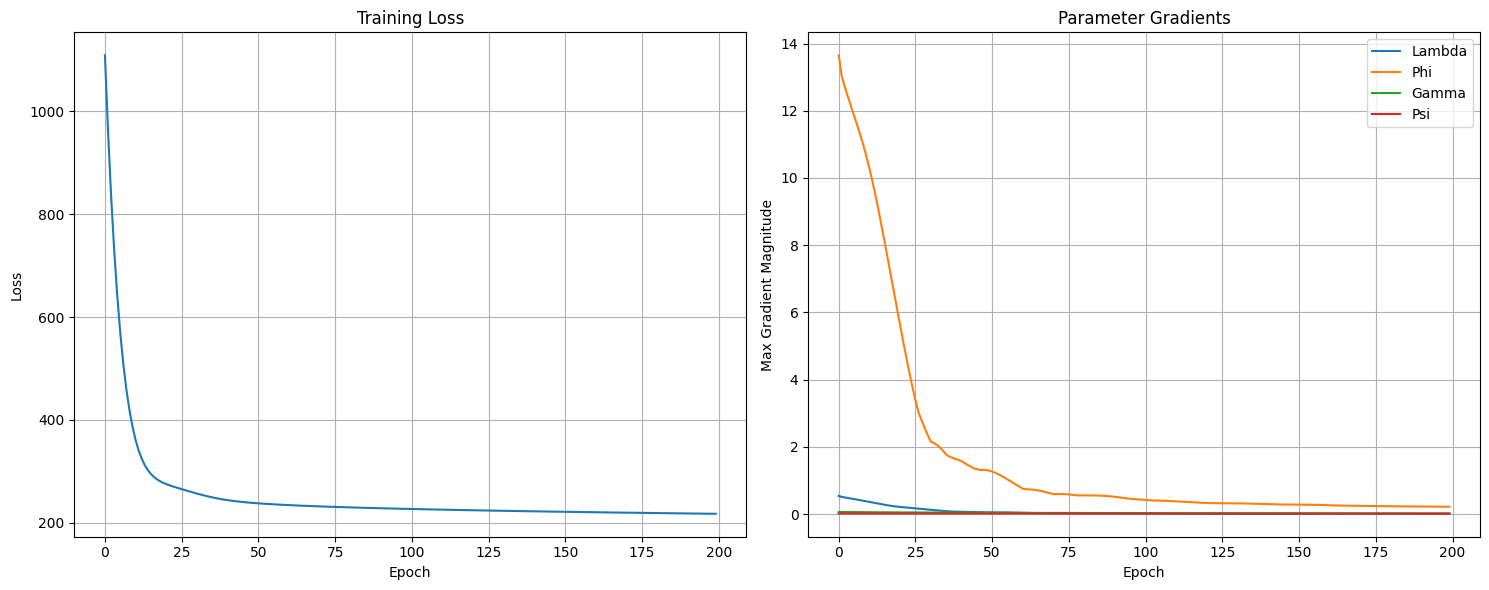

In [11]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [12]:
disease_names=essentials['disease_names']

In [13]:
import torch

# Save complete state for R
save_path = '12model_complete_for_R_1219_14.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t':essentials['prevalence_t'],
    'loit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E,
    'indices' : indices,
    'disease_names': disease_names,
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T':Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, save_path)

In [14]:
import pickle
checkpoint = torch.load('12model_complete_for_R_1216_12.pt')

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_80944/3189223256.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('12model_complete_for

FileNotFoundError: [Errno 2] No such file or directory: '12model_complete_for_R_1216_12.pt'

In [ ]:
initial_gamma

In [ ]:

model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model.gamma-initial_gamma
model.phi-initial_phi

In [ ]:
initial_gamma[0,0]


In [ ]:

model.gamma[0,0]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert gamma tensors to numpy arrays
initial_gamma_np = initial_gamma.detach().numpy()
final_gamma_np = model.gamma.detach().numpy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial gamma
sns.heatmap(initial_gamma_np, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Gamma')

# Plot final gamma
sns.heatmap(final_gamma_np, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Gamma')

# Add a title to the figure
plt.suptitle('Comparison of Initial vs Final Gamma Values', fontsize=16)

# You can also add a colorbar
plt.tight_layout()

# To see the actual difference, you can also create a difference heatmap
plt.figure(figsize=(10, 8))
diff = final_gamma_np - initial_gamma_np
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Difference (Final - Initial Gamma)')
plt.show()

# Print some summary statistics
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff):.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert phi tensors to numpy arrays
initial_phi_np = initial_phi.detach().numpy()  # Shape: (K, D, T)
final_phi_np = model.phi.detach().numpy()

# Take mean over time dimension
initial_phi_mean = initial_phi_np.mean(axis=2)  # Shape: (K, D)
final_phi_mean = final_phi_np.mean(axis=2)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial phi (averaged over time)
sns.heatmap(initial_phi_mean, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Phi (Mean over Time)')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Signature')

# Plot final phi (averaged over time)
sns.heatmap(final_phi_mean, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Phi (Mean over Time)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Signature')

plt.suptitle('Comparison of Initial vs Final Phi Values (Averaged over Time)', fontsize=16)
plt.tight_layout()

# Plot difference
plt.figure(figsize=(10, 8))
diff_mean = final_phi_mean - initial_phi_mean
sns.heatmap(diff_mean, cmap='RdBu_r', center=0)
plt.title('Difference in Phi (Final - Initial), Mean over Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

# Print summary statistics for both full tensor and time-averaged differences
print("Full tensor statistics:")
diff_full = final_phi_np - initial_phi_np
print(f"Mean absolute difference: {np.abs(diff_full).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_full).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_full):.4f}")

print("\nTime-averaged statistics:")
print(f"Mean absolute difference: {np.abs(diff_mean).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_mean).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_mean):.4f}")

# Optionally, look at temporal variation
temporal_std = np.std(diff_full, axis=2)
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_std, cmap='viridis')
plt.title('Standard Deviation of Changes Across Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

In [47]:
def track_gamma_changes(initial_gamma, current_gamma):
    diff = (current_gamma - initial_gamma).abs()
    print(f"Gamma changes:")
    print(f"Mean change: {diff.mean():.8f}")
    print(f"Max change: {diff.max():.8f}")
    print(f"Std of changes: {diff.std():.8f}")

In [ ]:
diff = (model.gamma - initial_gamma).abs()
diff

In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

In [ ]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, disease_names)

In [ ]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, disease_names)

In [ ]:

model.visualize_clusters(disease_names)
model.visualize_initialization()

In [ ]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
plot_signature_temporal_patterns(model, disease_names, selected_signatures=[0,1,14,15,16,13,17])